In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

config_file = '../configs/detr/detr_r50_8x2_150e_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '../checkpoints/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
result = inference_detector(model, 'demo_800_800.jpg')

TypeError: expected str, bytes or os.PathLike object, not NoneType

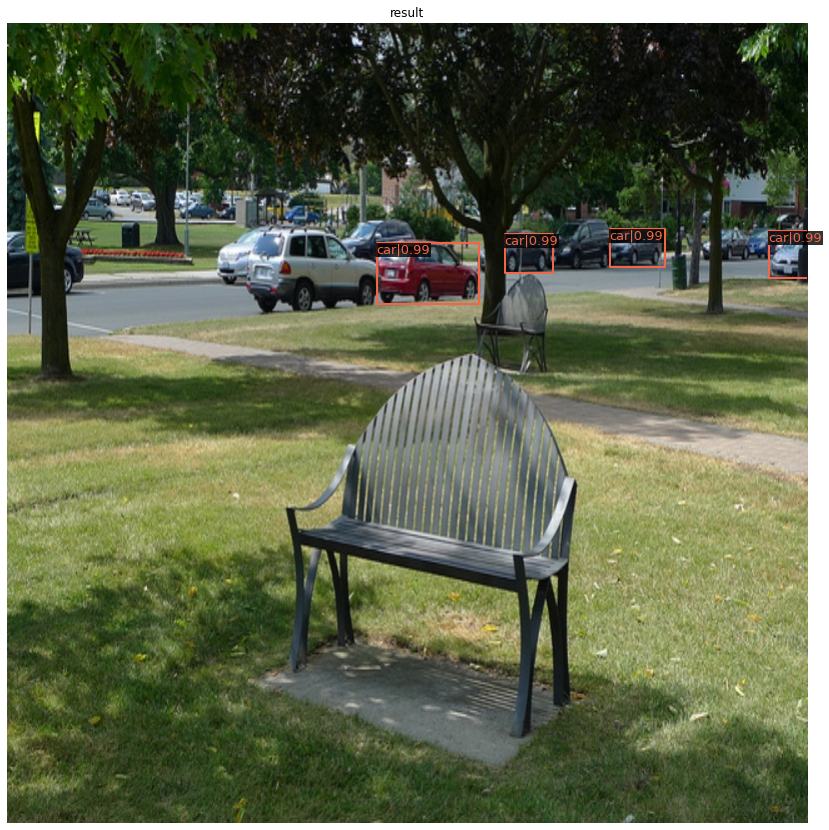

In [2]:
show_result_pyplot(model, "demo_800_800.jpg", result, score_thr=0.99)

In [5]:
import torch
from mmdet.models.dense_heads.retina_head import RetinaHead
import numpy as np
import torch
from mmdet.datasets import replace_ImageToTensor
from mmcv.parallel import collate, scatter
from mmdet.datasets.pipelines import Compose
from mmdet.apis import (async_inference_detector, inference_detector,
                        init_detector, show_result_pyplot)

In [6]:
    cfg = model.cfg
    imgs = 'demo_800_800.jpg'
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    # cfg = model.cfg
    # device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]

In [7]:
x = data['img'][0].reshape(1,3,800,800)

In [8]:
import onnx
onnx_model = onnx.load("../detr_resnet50_sim_changed.onnx")
onnx.checker.check_model(onnx_model)

In [9]:

import cv2
from PIL import Image
import numpy as np
import os
import random
 
try:
    import onnxruntime
except ImportError:
    onnxruntime = None
 
import torch
import torchvision.transforms as T
 
torch.set_grad_enabled(False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
 
 
def box_cxcywh_to_xyxy(x):
    x = torch.from_numpy(x)
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
 
 
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b.cpu().numpy()
    b = b * np.array([img_w, img_h, img_w, img_h], dtype=np.float32)
    return b
 
 
def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
 
 
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
 
 
def plot_result(pil_img, prob, boxes, save_name=None, imshow=False, imwrite=False):
    cv2Image = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
 
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes):
        cl = p.argmax()
        label_text = '{} {}%'.format(CLASSES[cl], round(p[cl] * 100, 2))
        plot_one_box((xmin, ymin, xmax, ymax), cv2Image, label=label_text)
 
    if imshow:
        cv2.imshow('detect', cv2Image)
        cv2.waitKey(0)
 
    if imwrite:
        if not os.path.exists("onnx/result"):
            os.makedirs('onnx/result')
        cv2.imwrite('onnx/result/{}'.format(save_name), cv2Image)
 
 
def detect_onnx(ort_session, im, prob_threshold=0.7):
    img = transform(im).unsqueeze(0).cpu().numpy()
    ort_inputs = {"inputs": img}
    scores, boxs = ort_session.run(None, ort_inputs)
    probas = torch.from_numpy(np.array(scores)).softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > prob_threshold
    probas = probas.cpu().detach().numpy()
    keep = keep.cpu().detach().numpy()
    bboxes_scaled = rescale_bboxes(boxs[0, keep], im.size)
    return probas[keep], bboxes_scaled

In [10]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("../detr_resnet50_sim_changed.onnx")
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [24]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
scores, boxes = ort_session.run(None, ort_inputs)

In [25]:
boxes = boxes[0]
scores = scores[0]

In [33]:
scores = torch.from_numpy(scores)

In [35]:
scores_torch = torch.softmax(scores,dim=1)

In [37]:
scores_torch.min()

tensor(2.1488e-12)

In [40]:
for i in range(100):
    for j in range(92):
        if scores_torch[i][j] > 0.99:
            print(i,j)

34 3
43 3
48 3
58 3
91 3
92 62


In [63]:
boxes[92]

array([0.632968  , 0.38004932, 0.09362969, 0.12350169], dtype=float32)

In [64]:
[x1, y1, x2, y2] = [boxes[92][0]-0.5*boxes[92][2],  boxes[92][1]-0.5*boxes[92][3]  , boxes[92][0]+0.5*boxes[92][2],boxes[92][1]+0.5*boxes[92][3]]

In [65]:
[800* x1,800 * y1, 800 * x2, 800 * y2] 

[468.92253160476685, 254.6387791633606, 543.8262820243835, 353.4401297569275]

In [67]:

import cv2
 
image = cv2.imread('./demo_800_800.jpg')
a = (235, 205, 372, 288)
b = (764, 208, 800, 256)
c = (0, 213, 79, 270)
d = (337, 198, 407, 237)
e = (469, 255, 544, 353)
# 左上角和右下角
cv2.rectangle(image, (a[0], a[1]), (a[2], a[3]), (0, 0, 255), 2)
cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
cv2.rectangle(image, (c[0], c[1]), (c[2], c[3]), (0, 0, 255), 2)
cv2.rectangle(image, (d[0], d[1]), (d[2], d[3]), (0, 0, 255), 2)
cv2.rectangle(image, (e[0], e[1]), (e[2], e[3]), (0, 0, 255), 2)

cv2.imwrite('demp.jpg', image)


True